In [ ]:
!pip uninstall torch-geometric -y
!pip install torch-geometric --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00


In [ ]:
!pip show torch-geometric

Name: torch-geometric
Version: 2.6.1
Summary: Graph Neural Network Library for PyTorch
Home-page: https://pyg.org
Author: 
Author-email: Matthias Fey <matthias@pyg.org>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, fsspec, jinja2, numpy, psutil, pyparsing, requests, tqdm
Required-by: 


In [ ]:
from torch_geometric.datasets import Planetoid
import networkx as nx

dataset = Planetoid(root='./data/Cora', name='Cora')
data = dataset[0]

# Convert to NetworkX graph for easier manipulation
edge_index = data.edge_index.numpy()
edges = [(edge_index[0, i], edge_index[1, i]) for i in range(edge_index.shape[1])]
G = nx.Graph()
G.add_edges_from(edges)
# Get node degrees
degrees = dict(G.degree())
print(f"Cora dataset has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Processing...


Cora dataset has 2708 nodes and 5278 edges


Done!


In [ ]:
# Extract dataset properties
num_nodes = data.num_nodes
num_edges = data.edge_index.size(1)
num_features = data.num_features
num_classes = dataset.num_classes
# Extract masks
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask
print(f"Cora Dataset Statistics:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Number of node features: {num_features}")
print(f"Number of classes: {num_classes}")
print(f"Number of training nodes: {train_mask.sum().item()}")
print(f"Number of validation nodes: {val_mask.sum().item()}")
print(f"Number of test nodes: {test_mask.sum().item()}")

# Analyze class distribution
class_distribution = [0] * num_classes
for i in range(num_classes):
  class_distribution[i] = (data.y == i).sum().item()

print(f"Class distribution: {class_distribution}")

Cora Dataset Statistics:
Number of nodes: 2708
Number of edges: 10556
Number of node features: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Class distribution: [351, 217, 418, 818, 426, 298, 180]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import networkx as nx

class LINE(nn.Module):
  def __init__(self, num_nodes, embedding_dim=128):
    """
    Initialize the LINE model for first-order proximity

    Args:
    num_nodes: Number of nodes in the graph
    embedding_dim: Dimension of node embeddings
    """
    super(LINE, self).__init__()
    self.num_nodes = num_nodes
    self.embedding_dim = embedding_dim

    # Node embedding layer
    self.node_embeddings = nn.Embedding(num_nodes, embedding_dim)

    # Initialize embeddings
    self.init_weights()

  def init_weights(self):
    """Initialize embeddings with small random values"""
    initrange = 0.5 / self.embedding_dim
    self.node_embeddings.weight.data.uniform_(-initrange, initrange)

  def forward(self, v_i, v_j, neg_samples):
    """
    Forward pass of LINE with negative sampling

    Args:
    v_i: Tensor of source node indices
    v_j: Tensor of target node indices (positive samples)
    neg_samples: Tensor of negative sample indices for each source node

    Returns:
    loss: The negative sampling loss
    """
    # TODO: Implement the forward pass





    # 1. Get embeddings for source nodes, positive target nodes, and negative samples
    emb_i = self.node_embeddings(v_i)
    emb_j = self.node_embeddings(v_j)
    emb_neg = self.node_embeddings(neg_samples)

    # 2. Compute dot products between source and positive target embeddings

    # Positive score: dot product for each positive pair
    pos_score = torch.sum(emb_i * emb_j, dim=1)  # [batch_size]
    # 4. Calculate positive term: log(σ(u Ti uj ))

    pos_loss = -F.logsigmoid(pos_score).mean()

    # 3. Compute dot products between source and negative sample embeddings
    # 5. Calculate negative term: P(log(σ(−u T i uneg)))
    neg_score = torch.bmm(emb_neg, emb_i.unsqueeze(2)).squeeze(2)
    neg_loss = -F.logsigmoid(-neg_score).mean()

    # 6. Return the combined loss
    loss = pos_loss + neg_loss
    return loss


  def generate_negative_samples(self, edges, num_neg_samples, node_degrees):
    """
    Generate negative samples according to the noise distribution Pn(v) ∝ d 3/4

    Args:
    edges: List of edges (source, target pairs)
    num_neg_samples: Number of negative samples to generate per edge
    node_degrees: Dictionary of node degrees

    Returns:
    neg_samples: Tensor of negative samples for each edge
    """
    # TODO: Implement negative sampling





    # return neg_sample


    all_nodes = np.arange(self.num_nodes)

    # 1. Calculate sampling probability for each node based on degreeˆ(3/4)
    weights = np.array([node_degrees.get(node, 1)**0.75 for node in all_nodes])
    # 2. Normalize probabilities to create a distribution
    probabilities = weights / weights.sum()

    # 3. For each edge, sample negative nodes that are not connected to the source
    neg_samples_list = []
    for edge in edges:

        neg_samples = np.random.choice(all_nodes, size=num_neg_samples, replace=True, p=probabilities)
        neg_samples_list.append(neg_samples)

    # 4. Return tensor of negative samples
    neg_samples_tensor = torch.tensor(neg_samples_list, dtype=torch.long)
    return neg_samples_tensor

    return 0

In [ ]:
# Create a small test graph
G_test = nx.karate_club_graph()
degrees = dict(G_test.degree())
edges = list(G_test.edges())
model = LINE(G_test.number_of_nodes())
# Generate some negative samples and calculate loss
source_nodes = torch.tensor([edge[0] for edge in edges[:5]])
target_nodes = torch.tensor([edge[1] for edge in edges[:5]])
neg_samples = model.generate_negative_samples(edges[:5], 5, degrees)
loss = model(source_nodes, target_nodes, neg_samples)
print(f"Loss on test batch: {loss.item()}")

Loss on test batch: 1.3863272666931152


<ipython-input-5-f18a69a81792>:110: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  neg_samples_tensor = torch.tensor(neg_samples_list, dtype=torch.long)


In [ ]:
def train_line(model, graph, num_epochs=100, batch_size=64, neg_samples=5, learning_rate=0.01):
  """
  Train the LINE model on the given graph

  Args:
    model: LINE model instance
    graph: NetworkX graph
    num_epochs: Number of training epochs
    batch_size: Size of each training batch
    neg_samples: Number of negative samples per positive edge
    learning_rate: Learning rate for optimization
  Returns:
    model: Trained LINE model
    losses: List of loss values during training
    """
  # TODO: Implement the training pipeline








  # 1. Get all edges from the graph
  edges = list(graph.edges())
  # Compute node degrees for negative sampling
  node_degrees = dict(graph.degree())

  # 2. Create optimizer
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  losses = []

  # 3. For each epoch:
  for epoch in range(num_epochs):
      random.shuffle(edges) # a. Shuffle edges
      epoch_loss = 0.0
      num_batches = 0

      # b. Create batches of edges
      # c. For each batch:
      for i in range(0, len(edges), batch_size):
          batch_edges = edges[i: i + batch_size]

          source_nodes = torch.tensor([edge[0] for edge in batch_edges], dtype=torch.long)
          target_nodes = torch.tensor([edge[1] for edge in batch_edges], dtype=torch.long)

          # i. Generate negative samples
          neg_samples_tensor = model.generate_negative_samples(batch_edges, neg_samples, node_degrees)

          # ii. Calculate loss
          optimizer.zero_grad()
          loss = model(source_nodes, target_nodes, neg_samples_tensor)

          # iii. Backpropagate and update parameters
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()
          num_batches += 1

      # d. Track and report average loss per epoch
      avg_loss = epoch_loss / num_batches
      losses.append(avg_loss)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

  # 4. Return trained model and loss history
  return model, losses



In [ ]:

# Create mapping from a bug after indexing issue
mapping = {node: i for i, node in enumerate(G.nodes())}


graph = nx.relabel_nodes(G, mapping)
model = LINE(num_nodes=G.number_of_nodes())

In [ ]:
#model, loss_history = train_line(model, graph, num_epochs=2000, batch_size=64, neg_samples=5, learning_rate=0.4)


In [ ]:
import re
data = """

"""
loss_history = [float(match) for match in re.findall(r"Loss:\s*([0-9.]+)", data)]


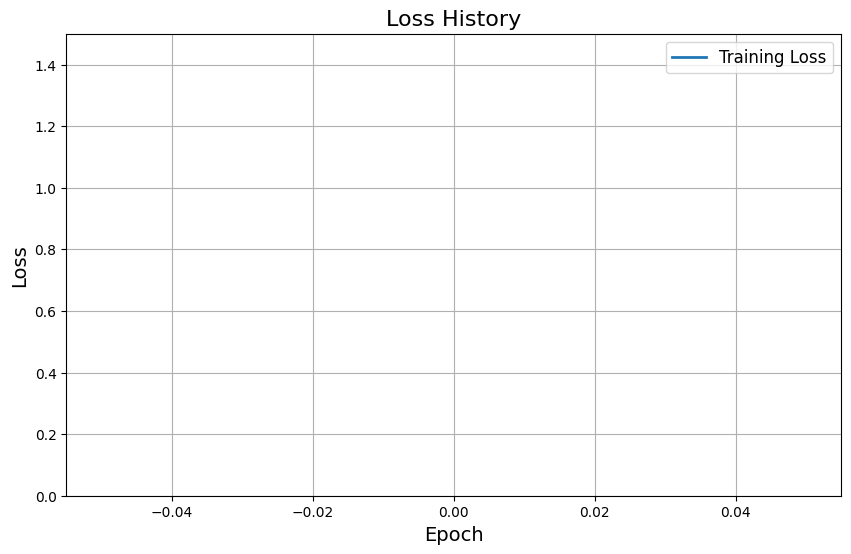

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss History', fontsize=16)
plt.legend(fontsize=12)
plt.ylim(0, 1.5)
plt.grid(True)
plt.show()


In [ ]:
!pip install scikit-learn

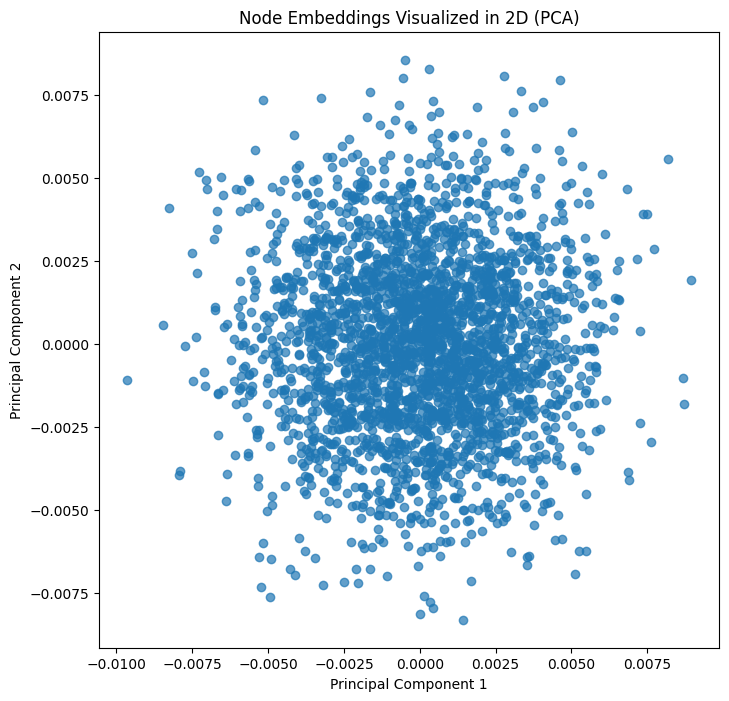

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def visualize_embeddings(model):

    embeddings = model.node_embeddings.weight.data.cpu().numpy()

    # PCA documentaiton: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    plt.title("Node Embeddings Visualized in 2D (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


visualize_embeddings(model)

In [ ]:
import networkx as nx
import random
from collections import defaultdict


In [ ]:
def uniform_random_walk(graph, start_node, walk_length):
  """
  Perform a uniform random walk on the graph starting from start_node
  Args:
    graph: NetworkX graph
    start_node: Starting node for the walk
    walk_length: Length of the walk

  Returns:
    walk: List of nodes in the walk
  """
  # TODO: Implement uniform random walk
  # 1. Initialize walk with the start node


  walk = [start_node]
  current = start_node
  # 2. For each step,
  for _ in range(walk_length - 1):
      # randomly select a neighbor of the current node
      neighbors = list(graph.neighbors(current))
      if not neighbors:
          break
      current = random.choice(neighbors)
      walk.append(current)
  # 3. Return the completed walk
  return walk


def biased_random_walk(graph, start_node, walk_length, p, q):
  """
  Perform a biased random walk following the Node2Vec algorithm

  Args:
    graph: NetworkX graph
    start_node: Starting node for the walk
    walk_length: Length of the walk
    p: Return parameter (controls backtracking)
    q: In-out parameter (controls BFS vs. DFS behavior)

  Returns:
    walk: List of nodes in the walk
  """
  # TODO: Implement biased random walk



  # 1. Initialize walk with the start node
  walk = [start_node]
  if walk_length == 1:
      return walk

  # 2. If this is the first step, choose uniformly among neighbors
  current = start_node
  neighbors = list(graph.neighbors(current))
  if not neighbors:
      return walk
  next_node = random.choice(neighbors)
  walk.append(next_node)

  # 3. For subsequent steps:
  for _ in range(walk_length - 2):
      # a. Identify the previous node in the walk
      prev = walk[-2]
      current = walk[-1]
      neighbors = list(graph.neighbors(current))
      if not neighbors:
          break
      weights = []
      # b. Calculate transition probabilities based on p and q
      # c. Sample the next node according to these probabilities

      for neighbor in neighbors:
          if neighbor == prev:
              weight = 1.0 / p
          elif graph.has_edge(prev, neighbor):
              weight = 1.0
          else:
              weight = 1.0 / q
          weights.append(weight)
      total_weight = sum(weights)
      probabilities = [w / total_weight for w in weights]
      next_node = random.choices(neighbors, weights=probabilities, k=1)[0]
      walk.append(next_node)
  # 4. Return the completed walk
  return walk



In [ ]:
!pip uninstall torch-geometric -y
!pip install torch-geometric --no-cache-dir

Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00


In [ ]:
def evaluate_walks(graph, walks):
    """
    Compute:
    - average distance (shortest path from start to each node in the walk),
    - revisit frequency,
    - and coverage (unique nodes) for a list of walks.
    """
    total_distance = 0
    total_nodes = 0
    total_revisits = 0
    total_unique = 0

    for walk in walks:
        start = walk[0]
        walk_distance = 0
        revisits = 0
        seen = set()
        seen.add(start)
        for node in walk[1:]:
            try:
                d = nx.shortest_path_length(graph, source=start, target=node)
            except nx.NetworkXNoPath:
                d = float('inf')
            walk_distance += d
            total_nodes += 1
            if node in seen:
                revisits += 1
            else:
                seen.add(node)
        total_distance += walk_distance
        total_revisits += revisits
        total_unique += len(seen)

    avg_distance = total_distance / total_nodes if total_nodes > 0 else 0
    avg_revisit_freq = total_revisits / total_nodes if total_nodes > 0 else 0
    avg_coverage = total_unique / len(walks) if walks else 0

    return {
        'average_distance': avg_distance,
        'revisit_frequency': avg_revisit_freq,
        'average_coverage': avg_coverage
    }

def generate_walks(graph, walk_fn, num_walks=100, walk_length=10, **kwargs):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        start = random.choice(nodes)
        walk = walk_fn(graph, start, walk_length, **kwargs) if kwargs else uniform_random_walk(graph, start, walk_length)
        walks.append(walk)
    return walks

# Same implementation as 1.1 & 1.2
from torch_geometric.datasets import Planetoid
import networkx as nx

dataset = Planetoid(root='./data/Cora', name='Cora')
data = dataset[0]

# Convert to NetworkX graph for easier manipulation
edge_index = data.edge_index.numpy()
edges = [(edge_index[0, i], edge_index[1, i]) for i in range(edge_index.shape[1])]
G = nx.Graph()
G.add_edges_from(edges)
# Get node degrees
degrees = dict(G.degree())
print(f"Cora dataset has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


uniform_walks = generate_walks(G, uniform_random_walk, num_walks=100, walk_length=10)
uniform_stats = evaluate_walks(G, uniform_walks)
print("Uniform Random Walk Stats:", uniform_stats)

for p, q in [(0.25, 0.25), (0.25, 4), (4, 0.25), (4, 4)]:
    node2vec_walks = generate_walks(G, biased_random_walk, num_walks=100, walk_length=10, p=p, q=q)
    stats = evaluate_walks(G, node2vec_walks)
    print(f"Node2Vec Walk Stats for p={p}, q={q}:", stats)

Cora dataset has 2708 nodes and 5278 edges
Uniform Random Walk Stats: {'average_distance': 2.1533333333333333, 'revisit_frequency': 0.3522222222222222, 'average_coverage': 6.83}
Node2Vec Walk Stats for p=0.25, q=0.25: {'average_distance': 2.1055555555555556, 'revisit_frequency': 0.3655555555555556, 'average_coverage': 6.71}
Node2Vec Walk Stats for p=0.25, q=4: {'average_distance': 1.1022222222222222, 'revisit_frequency': 0.6744444444444444, 'average_coverage': 3.93}
Node2Vec Walk Stats for p=4, q=0.25: {'average_distance': 2.5077777777777777, 'revisit_frequency': 0.16666666666666666, 'average_coverage': 8.5}
Node2Vec Walk Stats for p=4, q=4: {'average_distance': 1.8588888888888888, 'revisit_frequency': 0.38555555555555554, 'average_coverage': 6.53}


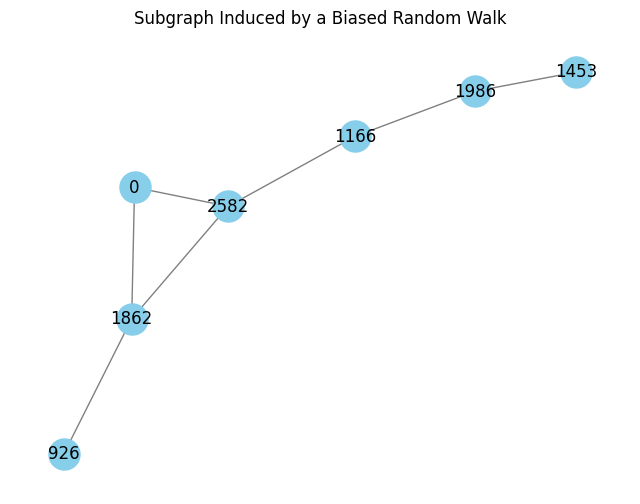

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
# Let's also see how P & Q are actually affecting the Random Walk

def visualize_walk_subgraph(graph, walk):
    """
    Visualize the subgraph induced by the nodes in the walk.

    Args:
      graph: A NetworkX graph.
      walk: A list of node IDs representing a random walk.
    """
    unique_nodes = set(walk)
    subgraph = graph.subgraph(unique_nodes).copy()

    pos = nx.spring_layout(subgraph, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, font_size=12, font_color='black')

    plt.title("Subgraph Induced by a Biased Random Walk")
    plt.axis("off")
    plt.show()

# Used both Biased & Unbiased random walk to generate some graphs for Report
walk = biased_random_walk(G, start_node=0, walk_length=30, p=4, q=4)
visualize_walk_subgraph(G, walk)


In [ ]:
class SkipGramModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim

        # Target and context embeddings
        self.target_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.context_embeddings = nn.Embedding(num_nodes, embedding_dim)

        # Initialize embeddings using Xavier initialization
        self.init_weights()

    def init_weights(self):
        """Initialize embeddings with Xavier initialization"""
        nn.init.xavier_uniform_(self.target_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)

    def forward(self, target_nodes, context_nodes, negative_samples):
        target_emb = self.target_embeddings(target_nodes)
        context_emb = self.context_embeddings(context_nodes)
        negative_emb = self.context_embeddings(negative_samples)

        # Print shapes and values for debugging
        print(f"target_emb shape: {target_emb.shape}")
        print(f"context_emb shape: {context_emb.shape}")
        print(f"negative_emb shape before reshape: {negative_emb.shape}")

        # Ensure `negative_emb` has correct shape (batch_size, num_neg_samples, embedding_dim)
        if len(negative_emb.shape) == 2:
            negative_emb = negative_emb.unsqueeze(0)  # Convert (batch_size, embedding_dim) → (batch_size, 1, embedding_dim)

        print(f"negative_emb shape after reshape: {negative_emb.shape}")

        # Ensure target_emb is 3D before matrix multiplication
        target_emb_unsqueezed = target_emb.unsqueeze(2)  # (batch_size, embedding_dim, 1)
        print(f"target_emb_unsqueezed shape: {target_emb_unsqueezed.shape}")

        # Compute positive loss
        pos_score = torch.mul(target_emb, context_emb).sum(dim=1)
        pos_loss = F.logsigmoid(pos_score)
        print(f"Positive Loss: {pos_loss.mean().item()}")

        # Compute negative loss
        neg_score = torch.bmm(negative_emb, target_emb_unsqueezed).squeeze(2)  # [batch_size, num_neg_samples]
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)
        print(f"Negative Loss: {neg_loss.mean().item()}")

        # Final loss
        loss = -(pos_loss + neg_loss).mean()
        print(f"Total Loss: {loss.item()}")

        # Backward pass with retain_graph=True if you plan to backpropagate more than once
        loss.backward(retain_graph=True)

        # Check the embeddings after the backward pass
        print(f"Gradients of target embeddings: {self.target_embeddings.weight.grad.sum()}")
        print(f"Gradients of context embeddings: {self.context_embeddings.weight.grad.sum()}")

        # Check if the embeddings are changing (they should if gradients are non-zero)
        print(f"Target Embeddings after backward pass: {self.target_embeddings.weight[:5]}")
        print(f"Context Embeddings after backward pass: {self.context_embeddings.weight[:5]}")

        return loss

In [ ]:
def generate_training_samples(walks, window_size, num_negative_samples, node_degrees):
    """
    Generate training samples from random walks

    Args:
    walks: List of random walks
    window_size: Context window size (how many nodes before and after to consider as context)
    num_negative_samples: Number of negative samples per positive sample
    node_degrees: Dictionary of node degrees for negative sampling

    Returns:
    samples: List of (target, context, negative_samples) tuples
    """
    print("Start generating training samples")
    samples = []
    nodes = list(node_degrees.keys())

    # Precompute probability distribution for negative sampling
    prob_dist = np.array([node_degrees[n] ** 0.75 for n in nodes])
    prob_dist /= prob_dist.sum()

    for walk_id, walk in enumerate(walks):
        for i, target in enumerate(walk):
            context_window = walk[max(0, i - window_size) : min(len(walk), i + window_size + 1)]
            context_window = [node for node in context_window if node != target]

            for context in context_window:
                neg_samples = np.random.choice(nodes, num_negative_samples, p=prob_dist, replace=False)
                samples.append((target, context, neg_samples))

        if walk_id % 100 == 0:  # Print progress every 100 walks
            print(f"Processed {walk_id}/{len(walks)} walks...")

    print("Finished generating training samples")
    return samples

In [ ]:
def train_node2vec(graph, walk_method, embedding_dim=128, num_walks=10, walk_length=80,
                   window_size=10, neg_samples=5, num_epochs=5, learning_rate=0.025,
                   p=1.0, q=1.0):
    """
    Train node embeddings using random walks and Skip-Gram

    Args:
    graph: NetworkX graph
    walk_method: Function to generate walks (uniform_random_walk or biased_random_walk)
    embedding_dim: Dimension of node embeddings
    num_walks: Number of walks per node
    walk_length: Length of each walk
    window_size: Context window size for Skip-Gram
    neg_samples: Number of negative samples per positive context
    num_epochs: Number of training epochs
    learning_rate: Learning rate for optimization
    p: Return parameter (only for biased walks)
    q: In-out parameter (only for biased walks)

    Returns:
    embeddings: Learned node embeddings
    """
    nodes = list(graph.nodes())
    node_degrees = dict(graph.degree())

    print("Generating random walks...")
    # Generate random walks
    walks = []
    for _ in range(num_walks):
        for node in nodes:
            if walk_method == uniform_random_walk:
              walks.append(walk_method(graph, node, walk_length))
            else:
              walks.append(walk_method(graph, node, walk_length, p, q))
            if node % 100 == 0:  # Print every 100 nodes
                print(f"Walk {node+1}/{num_walks}, Node {node}/{len(nodes)}")

    print("Generating training samples...")
    # Generate training samples
    training_samples = generate_training_samples(walks, window_size=3, num_negative_samples=2, node_degrees=node_degrees)
    print(f"Generated {len(training_samples)} training samples")

    # Initialize model and optimizer
    model = SkipGramModel(len(nodes), embedding_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Convert node indices to tensors
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}

    print("Starting training loop...")
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        random.shuffle(training_samples)

        for target, context, negatives in training_samples:
            target_tensor = torch.tensor([node_to_idx[target]], dtype=torch.long)
            context_tensor = torch.tensor([node_to_idx[context]], dtype=torch.long)
            negative_tensor = torch.tensor([node_to_idx[n] for n in negatives], dtype=torch.long)

            optimizer.zero_grad()
            loss = model(target_tensor, context_tensor, negative_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if i % 5000 == 0:
              print(f"Epoch {epoch+1}/{num_epochs}, Sample {i}/{len(training_samples)}, Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss/len(training_samples):.4f}")

    print("Training complete!")
    return model.target_embeddings.weight.detach().numpy()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress t-SNE warnings and logistic regression warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
def evaluate_embeddings(embeddings, labels, train_mask, val_mask, test_mask):
    """
    Evaluate embeddings on a node classification task using logistic regression

    Args:
    embeddings: Node embeddings matrix [num_nodes, embedding_dim]
    labels: Node labels [num_nodes]
    train_mask: Boolean mask for training nodes
    val_mask: Boolean mask for validation nodes
    test_mask: Boolean mask for test nodes

    Returns:
    test_accuracy: Classification accuracy on test set
    best_model: Best logistic regression model
    """

    print(f"embeddings shape: {embeddings.shape}")
    print(f"labels shape: {labels.shape}")
    print(f"train_mask shape: {train_mask.shape}, True count: {train_mask.sum().item()}")
    print(f"val_mask shape: {val_mask.shape}, True count: {val_mask.sum().item()}")
    print(f"test_mask shape: {test_mask.shape}, True count: {test_mask.sum().item()}")

    # Ensure embeddings are only for the subgraph nodes
    embeddings = embeddings[:labels.shape[0]]

    print(f"Filtered embeddings shape: {embeddings.shape} (should be 500, 128)")
    # Extract train/val/test embeddings and labels
    X_train, y_train = embeddings[train_mask], labels[train_mask]
    X_val, y_val = embeddings[val_mask], labels[val_mask]
    X_test, y_test = embeddings[test_mask], labels[test_mask]

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


    # Try different regularization strengths
    best_val_acc = 0
    best_model = None
    best_test_acc = 0

    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # Train logistic regression
        clf = LogisticRegression(C=C, max_iter=200, multi_class='multinomial', solver='lbfgs')
        clf.fit(X_train, y_train)

        # Evaluate on validation set
        val_acc = clf.score(X_val, y_val)

        # Keep track of the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = clf
            best_test_acc = clf.score(X_test, y_test)

    return best_test_acc, best_model

In [ ]:
import time

# Train LINE model
line_model = LINE(G.number_of_nodes(), embedding_dim=128)
line_model, _ = train_line(line_model, G, num_epochs=750, batch_size=64, neg_samples=5, learning_rate=0.4)

# Extract LINE embeddings
line_embeddings = line_model.node_embeddings.weight.detach().numpy()

def run_embedding_evaluation(graph, labels, train_mask, val_mask, test_mask):
    # Store results
    results = {}

    # Evaluate LINE separately
    print("Evaluating LINE embeddings...")
    line_test_acc, _ = evaluate_embeddings(line_embeddings, labels, train_mask, val_mask, test_mask)
    results["LINE (First-Order Proximity)"] = (line_test_acc, "Pretrained")

    # Define Node2Vec/DeepWalk methods
    methods = {
        "DeepWalk (p=1, q=1)": (1, 1),
        "Node2Vec (p=0.25, q=0.25)": (0.25, 0.25),
        "Node2Vec (p=0.25, q=4)": (0.25, 4),
        "Node2Vec (p=4, q=0.25)": (4, 0.25)
    }

    # Evaluate Node2Vec and DeepWalk
    for method, (p, q) in methods.items():
        print(f"Training {method}...")
        start_time = time.time()
        embeddings = train_node2vec(graph, uniform_random_walk, num_walks=5, walk_length=40, num_epochs=100, p=p, q=q)
        elapsed_time = time.time() - start_time
        print(f"{method} training completed in {elapsed_time:.2f} seconds")

        # Evaluate embeddings
        test_acc, _ = evaluate_embeddings(embeddings, labels, train_mask, val_mask, test_mask)
        results[method] = (test_acc, elapsed_time)

    # Final comparison
    print("\nFinal Comparison of Embedding Methods:")
    for method, (test_acc, elapsed_time) in results.items():
        print(f"{method}: Test Accuracy = {test_acc:.4f}, Training Time = {elapsed_time}")

    return results

Epoch 1/750, Loss: 1.3863
Epoch 2/750, Loss: 1.3863
Epoch 3/750, Loss: 1.3863
Epoch 4/750, Loss: 1.3863
Epoch 5/750, Loss: 1.3863
Epoch 6/750, Loss: 1.3863
Epoch 7/750, Loss: 1.3863
Epoch 8/750, Loss: 1.3863
Epoch 9/750, Loss: 1.3863
Epoch 10/750, Loss: 1.3863
Epoch 11/750, Loss: 1.3863
Epoch 12/750, Loss: 1.3863
Epoch 13/750, Loss: 1.3863
Epoch 14/750, Loss: 1.3863
Epoch 15/750, Loss: 1.3863
Epoch 16/750, Loss: 1.3863
Epoch 17/750, Loss: 1.3863
Epoch 18/750, Loss: 1.3863
Epoch 19/750, Loss: 1.3863
Epoch 20/750, Loss: 1.3863
Epoch 21/750, Loss: 1.3862
Epoch 22/750, Loss: 1.3862
Epoch 23/750, Loss: 1.3862
Epoch 24/750, Loss: 1.3862
Epoch 25/750, Loss: 1.3862
Epoch 26/750, Loss: 1.3862
Epoch 27/750, Loss: 1.3862
Epoch 28/750, Loss: 1.3862
Epoch 29/750, Loss: 1.3862
Epoch 30/750, Loss: 1.3862
Epoch 31/750, Loss: 1.3862
Epoch 32/750, Loss: 1.3862
Epoch 33/750, Loss: 1.3862
Epoch 34/750, Loss: 1.3862
Epoch 35/750, Loss: 1.3862
Epoch 36/750, Loss: 1.3862
Epoch 37/750, Loss: 1.3862
Epoch 38/7

In [ ]:
import random
import torch

# Create a smaller subgraph (500 random nodes)
small_node_set = random.sample(list(G.nodes()), 500)
subgraph = G.subgraph(small_node_set).copy()

# Extract nodes in the subgraph
subgraph_nodes = list(subgraph.nodes())

print(f"Subgraph has {len(subgraph_nodes)} nodes")

# Convert labels to subgraph indices
subgraph_labels = data.y[subgraph_nodes]
print(f"subgraph_labels shape: {subgraph_labels.shape}")

# Convert boolean masks to subgraph version
subgraph_train_mask = torch.tensor([data.train_mask[node].item() for node in subgraph_nodes], dtype=torch.bool)
subgraph_val_mask = torch.tensor([data.val_mask[node].item() for node in subgraph_nodes], dtype=torch.bool)
subgraph_test_mask = torch.tensor([data.test_mask[node].item() for node in subgraph_nodes], dtype=torch.bool)

# Print shapes and first 10 values to inspect
print(f"subgraph_train_mask shape: {subgraph_train_mask.shape}, True count: {subgraph_train_mask.sum().item()}")
print(f"subgraph_train_mask values: {subgraph_train_mask[:10]}")

print(f"subgraph_val_mask shape: {subgraph_val_mask.shape}, True count: {subgraph_val_mask.sum().item()}")
print(f"subgraph_val_mask values: {subgraph_val_mask[:10]}")

print(f"subgraph_test_mask shape: {subgraph_test_mask.shape}, True count: {subgraph_test_mask.sum().item()}")
print(f"subgraph_test_mask values: {subgraph_test_mask[:10]}")

# Run the evaluation on the smaller graph
results = run_embedding_evaluation(subgraph, subgraph_labels, subgraph_train_mask, subgraph_val_mask, subgraph_test_mask)


Streaming output truncated to the last 5000 lines.
          2.4461e+00,  1.7012e+00,  1.4936e+00,  2.5796e+00,  1.9827e-01,
          1.3444e+00, -9.7302e-02,  1.5498e+00,  2.9690e-01, -2.4849e+00,
          1.7428e+00,  1.9929e+00,  1.8226e+00, -3.6391e+00,  2.5602e+00,
          8.5996e-02,  1.8673e+00,  2.5541e-01,  1.3185e+00, -3.1462e+00,
         -3.6629e-01,  3.5922e+00,  1.8948e+00,  1.1806e+00,  1.0390e+00,
          1.3920e+00,  2.5443e-01,  2.3347e+00, -2.0672e+00, -2.2343e-01,
         -3.3871e+00, -2.7328e-01, -1.6598e+00, -1.5439e+00, -8.8377e-01,
          2.9242e+00, -6.1480e-01,  1.2951e+00,  5.4375e-01, -2.3361e+00,
         -1.0495e+00,  1.1646e+00, -2.5467e+00,  1.3158e+00,  2.4481e+00,
          5.7797e-01,  6.6807e-01,  2.2870e+00]], grad_fn=<SliceBackward0>)
Context Embeddings after backward pass: tensor([[ 1.5534e+00, -7.1594e-01, -9.5678e-01,  1.0848e+00,  7.2350e-01,
         -1.1950e+00, -8.9814e-02, -7.9025e-01, -3.0102e-01, -4.6646e-01,
          7.6572e-0

KeyboardInterrupt: 